# Hand Gesture Recognition
http://www.idiap.ch/resource/gestures/data/shp_marcel_train.tar.gz

Hardware Configuration:
Processor: Intel Xeon
RAM : 256 GB
Graphics Card: GTX 1080Ti (11 GB Memory)
CUDA 8

Software Configuraion:
Python - 2.7
Keras - 2.0.8  (Tensorflow Backend, 1.4.0)
Jupyter Notebook - 1.0.0 

### Load the modules
Keras  - Deep Learning Platform

PIL    - Image Processing Library

Matplotlib - Plotting Images

Numpy  - Array Transformations

OS     - Dealing with files

In [1]:
import pandas as pd
import numpy as np
import os
import PIL
from PIL import Image
from sklearn.cross_validation import train_test_split

from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.preprocessing import image
from keras import backend as K

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import *
%matplotlib inline

/home/vivekb/.local/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


## Transfer Learning
Training data available is hardly 5000 images. A deep conv net will easily overfit on such a small data.
Hence, a pretrained VGG16 network (trained on 1M images & 1000 classes) is used for getting feature representations of the images. These representations will be fed to a Multi Layer Perceptron for classification.

In [2]:
def VGG_16(weights_path=None):
    model = Sequential()
    model.add(ZeroPadding2D(padding=(1,1),input_shape=(224,224,3)))
    model.add(Convolution2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(ZeroPadding2D(padding=(1,1)))
    model.add(Convolution2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

    model.add(ZeroPadding2D(padding=(1,1)))
    model.add(Convolution2D(filters=128, kernel_size=(3, 3), activation='relu'))
    model.add(ZeroPadding2D(padding=(1,1)))
    model.add(Convolution2D(filters=128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

    model.add(ZeroPadding2D(padding=(1,1)))
    model.add(Convolution2D(filters=256, kernel_size=(3, 3), activation='relu'))
    model.add(ZeroPadding2D(padding=(1,1)))
    model.add(Convolution2D(filters=256, kernel_size=(3, 3), activation='relu'))
    model.add(ZeroPadding2D(padding=(1,1)))
    model.add(Convolution2D(filters=256, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

    model.add(ZeroPadding2D(padding=(1,1)))
    model.add(Convolution2D(filters=512, kernel_size=(3, 3), activation='relu'))
    model.add(ZeroPadding2D(padding=(1,1)))
    model.add(Convolution2D(filters=512, kernel_size=(3, 3), activation='relu'))
    model.add(ZeroPadding2D(padding=(1,1)))
    model.add(Convolution2D(filters=512, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

    model.add(ZeroPadding2D(padding=(1,1)))
    model.add(Convolution2D(filters=512, kernel_size=(3, 3), activation='relu'))
    model.add(ZeroPadding2D(padding=(1,1)))
    model.add(Convolution2D(filters=512, kernel_size=(3, 3), activation='relu'))
    model.add(ZeroPadding2D(padding=(1,1)))
    model.add(Convolution2D(filters=512, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

    model.add(Flatten())
    model.add(Dense(units=4096, activation='relu')) # 33rd layer in the network
    model.add(Dropout(rate=0.5))
    model.add(Dense(units=4096, activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(units=1000, activation='softmax'))

    if weights_path:
        model.load_weights(weights_path)

    return model

In [3]:
# Load the VGG weigths
path_weights_tf = 'vgg16_weights_tf_dim_ordering_tf_kernels.h5'
model = VGG_16(path_weights_tf)

In [4]:
# with a Sequential model, get output of only 33rd layer. 
get_33rd_layer_output = K.function([model.layers[0].input],
                                  [model.layers[32].output])

## Class Imbalance
It was observed during the training process that all the classes do not have equal proportion in population. Hence Some of the gestures were upsampled and some were down sampled. This decision was totally based on experimentation and emperical evidence.

Note: make sure the folder 'shp_marcel_train' is the current working directory

In [5]:
os.system('python under_sample_Point.py')

0

### Data Augmentation
The training data is limited and some of the gestures like 'A' and 'Point' have very sbuttle difference visually. Hence it is important for us to augment the training data to make the model robust to noise. Augmenting data includes randomly rotating the images, shifting them vertically and horizontally, and flipping them.

Below are the gesture labels in order: A, B, C, Five, Point, V

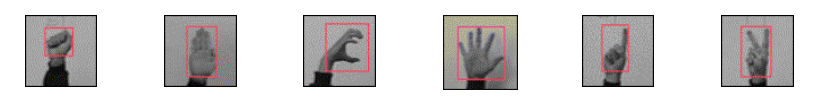

### Central Cropping
It was observed that most of the gestures were centrally located in the images. Emperically if was found out that cropping the images in the center (56x56 resolution) improved the classification performance.

### Do the necessary preprocessing required for VGG16 pretrained network
Since the network was trained in a particlar fashion, necessary preprocessing steps need to be followed. Resize the image to 224x224 resolution for consistency. Subtract the mean value of Imagenet training set from all colour channels.


In [6]:
hshift = 0.2
vshift = 0.2
rotate = 30
flip = 0.25

# Set seed for reprodicibility
np.random.seed(123)

# Function for data augmentation. 
# Input - Image, augmatation parameters
# Returns - Slightly transformed image. Acts as jittering
def augmentation(image, rotate = 0, hshift = 0, vshift =0, flip =0):
    imz = PIL.ImageChops.offset(image = image, xoffset=(np.random.uniform(0,hshift ,1)), yoffset=(np.random.uniform(0,vshift,1)))
    r = np.random.choice(np.arange(rotate),1)
    imz = imz.rotate(r)
    f= np.random.uniform(0,1,1)
    if f<flip:
        imz = imz.transpose(Image.FLIP_LEFT_RIGHT)
    return imz

# Function for Image cropping
# Input - Input and resolution parameter
# Output - Centrally Cropped Image of size (2mx2m)
def crop(img, m):
    half_the_width = img.size[0] / 2.
    half_the_height = img.size[1] / 2.
    img4 = img.crop((
    half_the_width - m,
    half_the_height - m,
    half_the_width + m,
    half_the_height + m))
    return(img4)

In [7]:
# Function for reading images from disk.
# Input: File name with path, 
#        probability for aumenting this image, 
#        parameter 'm' for cropping
# Returns: Preprocessed Image, ready for training. 
# This function internally calls 'augmentation' and 'crop' functions

size = 224
def read_image(f,prob,m):
    try:
        im = Image.open(f)
        im = crop(im,m)
        im = im.resize((size, size), PIL.Image.BILINEAR)
        if np.random.uniform(0,1,1)<prob:
            im = augmentation(image=im, rotate = rotate, hshift = hshift, vshift =vshift, flip =flip)
        im = np.array(im, dtype='float64')
        if len(im.shape)==2:
            im = im.reshape(im.shape[0],im.shape[1],1)
            im = im.repeat(3,axis=2)
        if im.shape[2]!=3:
            im = im[:,:,:3]
        im[:,:,0] -= 103.939
        im[:,:,1] -= 116.779
        im[:,:,2] -= 123.68
        im = im.reshape(1,224,224,3)
        return(im)
    except ValueError:
        print(f) #print the shape of im if it doesn't work correctly, don't reference this apriori

### A simple MLP for classification

In [8]:
# Calling this functions returns a simple 2 layer MLP with 6 nodes in the output
# Output Activation: Softmax
# Loss function: Cross Entropy

def mlp_network():
    mlp = Sequential()
    mlp.add(Dense(128, input_dim=4096, activation='relu'))
    mlp.add(Dropout(0.4))
    mlp.add(Dense(64, activation='relu'))
    mlp.add(Dropout(0.5))
    mlp.add(Dense(6, activation='softmax'))
    # mlp.summary()

    mlp.compile(optimizer='Adam', 
                loss='categorical_crossentropy', 
                metrics=['acc'])
    return(mlp)

### Split the data into Train and Test(Since we are already using the term 'validation for another dataset)

In [9]:
# This function splits the data into train and validation sets
# Input: path to the files on the disk
# Returns: Train and Validation files with their labels

def split_train_test(path):
    img_files_marcel = []
    for root, dirs, files in os.walk(path):
        img_files_marcel.extend([os.path.join(root,f) for f in files if f.endswith('.ppm')])
    #Shuffle the Marcel images
    n_files = len(img_files_marcel)
    print('Total number of train images:', n_files)
    sample_marcel = [img_files_marcel[i] for i in np.random.choice(len(img_files_marcel),size=n_files, replace=False)]
    
    k=0
    x_train_marcel = []
    y_train_marcel = []
    print('Reading Marcel train images ...')
    for f in sample_marcel:
        f_dir = (f.split('/')[-1]).split('-')[0]
        y_train_marcel.extend([0 if f_dir=='A' else 
                               1 if f_dir=='B' else 
                               2 if f_dir=='C' else 
                               3 if f_dir=='Five' else
                               4 if f_dir=='Point' else 5])
        x_train_marcel.append(f)
        k+=1
    
    x_tr, x_ts, y_tr, y_ts = train_test_split(x_train_marcel, y_train_marcel, test_size=0.10)
    return(x_tr, x_ts, y_tr, y_ts)

### Prepare the data for training

In [10]:
# This function takes the file names and returns the arrays for training
# Input: Image file names with path
# Returns: X, Y in arrays
# This function internally calls 'read_image' function with does the preprocessing.

def prepare_x_train(x_tr,y_tr):
    x_train=[]
    for i in range(len(x_tr)):
        if y_tr[i] in ['Point', 'V']:
            prob=0.5
        else:
            prob=0.25
        if y_tr[i] in ['Five','Point','V']:
            m=28
        else:
            m=28
        
        im1 = read_image(x_tr[i],prob,m)
        temp = get_33rd_layer_output([im1])[0]
        x_train.append(temp[0])
    return(np.array(x_train), np.array(y_tr))

### This is the training code block.

In [12]:
# We first split the dataset into train and test sets
# Test sets will not be involved in training. Hence could give an indication of model perforamance on unseen data.
# In every epoch, new training set will be created as augmentation will be done on randomly chosen images
# Emperically, it was found out that loss increases are 5-6 epochs. Hence, training will be done only for 5 epochs.

tr_acc = []
tr_loss = []
ts_acc = []
ts_loss = []

epochs = 1
path = '/home/vivekb/python/hackathon/handgesture/shp_marcel_train/Marcel-Train'
x_tr, x_ts, y_tr, y_ts = split_train_test(path)
x_test, y_test = prepare_x_train(x_ts,y_ts)
mlp = mlp_network()
for i in range(epochs):
    x_train, y_train = prepare_x_train(x_tr,y_tr)
    history = mlp.fit(x_train, to_categorical(y_train), 
                      validation_data=((x_test), to_categorical(y_test)),
                      epochs=1)
    tr_acc.append(history.history['acc'])
    tr_loss.append(history.history['loss'])
    ts_acc.append(history.history['val_acc'])
    ts_loss.append(history.history['val_loss'])

('Total number of train images:', 4671)
Reading Marcel train images ...
Train on 4203 samples, validate on 468 samples
Epoch 1/1
4203/4203 [==============================] - 0s - loss: 1.3348 - acc: 0.6010 - val_loss: 0.4714 - val_acc: 0.8462
Train on 4203 samples, validate on 468 samples
Epoch 1/1
4203/4203 [==============================] - 0s - loss: 0.5930 - acc: 0.7830 - val_loss: 0.2706 - val_acc: 0.9103
Train on 4203 samples, validate on 468 samples
Epoch 1/1
4203/4203 [==============================] - 0s - loss: 0.4488 - acc: 0.8425 - val_loss: 0.2321 - val_acc: 0.9124
Train on 4203 samples, validate on 468 samples
Epoch 1/1
4203/4203 [==============================] - 0s - loss: 0.3744 - acc: 0.8725 - val_loss: 0.1592 - val_acc: 0.9316
Train on 4203 samples, validate on 468 samples
Epoch 1/1
4203/4203 [==============================] - 0s - loss: 0.3525 - acc: 0.8846 - val_loss: 0.2119 - val_acc: 0.9252
Train on 4203 samples, validate on 468 samples
Epoch 1/1
4203/4203 [=====

### Plot for training and validation Accuracy, Loss

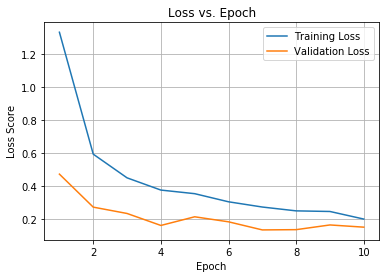

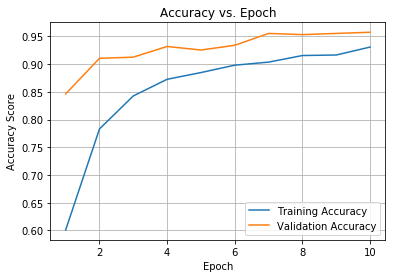

In [13]:
index = range(1,epochs+1)

#Plotting
import matplotlib.pyplot as plt
plt.plot(index, tr_loss)
plt.plot(index, ts_loss)
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss Score')
plt.title('Loss vs. Epoch')
plt.grid(True)
plt.show()

plt.plot(index, tr_acc)
plt.plot(index, ts_acc)
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Score')
plt.title('Accuracy vs. Epoch')
plt.grid(True)
plt.show()

### Save the model if it is better than previous ones
The last two digits indicate validation accuracy

In [20]:
# mlp.save('mlp_model_10_73.h5')

In [15]:
# This function takes the list of class predictions and returns the corresponding class labels
def get_labels(l):
    labels = ['A' if i==0 else 'B' if i==1 else 'C' if i==2 else 'Five' if i==3 else 'Point' if i==4 else 'V' for i in l]
    return(labels)

# This function takes the path for test files 
# input: parent directory's path for test files.
# Output: File names with class labels in the required format

full_val_path = []
def predictions_df(path):
    x_val = []
    for root, dirs, files in os.walk(path):
        files.sort(key=lambda f: int(filter(str.isdigit, f)))
        i=0
        for f in files:
            full_val_path.append(os.path.join(root,f))
            im1 = read_image(os.path.join(root,f), prob=0, m=28)
            temp = get_33rd_layer_output([im1])[0]
            x_val.append(temp[0])
            i+=1
    x_val = np.array(x_val)
    y_val = mlp.predict_classes(x_val)
    y_val_labels = get_labels(y_val)
    val_upload = pd.DataFrame({'FileName':files, 'Label':y_val_labels}, index=range(1,len(y_val_labels)+1))
    return(val_upload,x_val)

### Predictions

 32/170 [====>.........................] - ETA: 0s   FileName  Label
1     1.ppm      A
2     2.ppm      A
3     3.ppm      A
4     4.ppm      A
5     5.ppm      A
6     6.ppm      A
7     7.ppm      A
8     8.ppm      A
9     9.ppm  Point
10   10.ppm      A


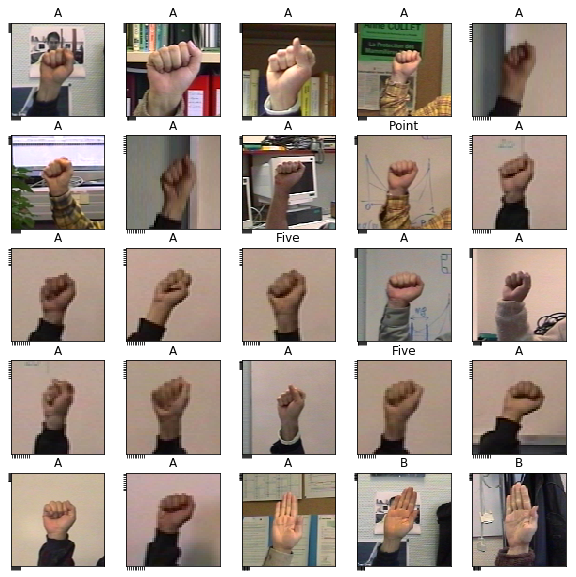

In [16]:
# Call the above 'prediction_df' function to get the labels for test files
val_path = '/home/vivekb/python/hackathon/handgesture/cross_validation_data/cross_validation_data/'
val_upload,x_val = predictions_df(val_path)
print(val_upload.head(10))

# Plot test images with predicted labels to get visual feedback
plt.figure(figsize=(10,10))
for i in range(1,26):
    plt.subplot(5,5,i)
    img = mpimg.imread(full_val_path[i])
    plt.imshow(img)
    x = range(10)
    plt.xticks(x," ")
    plt.yticks(x," ")
    plt.title((val_upload['Label'])[i])
plt.show()

### Write the predictions to disk

In [22]:
# val_upload.to_csv('my_predictions_10_73.csv', columns=['FileName', 'Label'], index=False)

### Manual analysis of class distribution in training and predictions

In [18]:
unq, count = np.unique(np.array(y_tr), return_counts=True)
print('Train Class Distribution')
print(np.asarray((unq, count)))

unq, count = np.unique(np.array(val_upload['Label']), return_counts=True)
print('Validation Prediction Class Distribution')
print(np.asarray((unq, count)))

val_actual = pd.read_csv('lables_cross_validation_1.csv', delimiter=',')
unq, count = np.unique(np.array(val_actual['Label']), return_counts=True)
print('Validation Actual Class Distribution')
print(np.asarray((unq, count)))

Train Class Distribution
[[   0    1    2    3    4    5]
 [2111  426  513  315  450  388]]
Validation Prediction Class Distribution
[['A' 'B' 'C' 'Five' 'Point' 'V']
 [25 21 31 36 37 20]]
Validation Actual Class Distribution
[['A' 'B' 'C' 'Five' 'Point' 'V']
 [23 22 29 29 24 43]]


### Confusion Matrix on validation data
This can give good insight into where the mis classifications are happening.

In [19]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(val_actual['Label'], val_upload['Label'])
print(cm)
acc = cm.trace()/np.sum(cm, dtype=np.float64)
print(acc)

[[20  0  0  2  1  0]
 [ 0 20  0  2  0  0]
 [ 0  0 28  1  0  0]
 [ 0  0  0 23  5  1]
 [ 5  0  1  0 16  2]
 [ 0  1  2  8 15 17]]
0.729411764706
